# Методы оптимизации в машинном обучении

In [1]:
import matplotlib.pyplot as plt
import scipy
import oracles
import numpy as np
import optimization
from sklearn.datasets import load_svmlight_file
import presubmit_tests as tests
from plot_trajectory_2d import plot_levels, plot_trajectory

Выполним тесты:

In [2]:
tests.test_python3()
tests.test_QuadraticOracle()
tests.test_log_reg_usual()
tests.test_log_reg_oracle_calls()
tests.test_grad_finite_diff_1()
tests.test_grad_finite_diff_2()
tests.test_hess_finite_diff_1()
tests.test_hess_finite_diff_2()
tests.test_line_search()
tests.test_gd_basic()
tests.test_newton_basic()
tests.test_newton_1d()
tests.test_newton_fail()

Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]


## 1. Эксперимент: Траектория градиентного спуска на квадратичной функции

Как отличается поведение метода в зависимости от числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная стратегия, Армихо, Вульф)?

In [3]:
x_start = np.array([[3., 4.], [2., -4.], [-1., -1.]])
methods = [{'method': 'Constant', 'c': 0.7}, {'method': 'Constant', 'c': 0.01}, 
           {'method': 'Armijo', 'alpha_0': 100.0, 'c1':0.9}, 
           {'method':'Armijo', 'alpha_0':1.0, 'c1':0.95}, 
           {"method":'Wolfe', 'c1':1e-4, 'c2':0.8, 'alpha_0':1.0}, 
           {"method":'Wolfe', 'c1':0.1, 'c2':0.95, 'alpha_0':100.0}]

### 1.1. Хорошо обусловленная матрица

In [4]:
A = np.array([[2.0, 0.], [0., 1.0]])
b = np.zeros(2)
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))

Число обусловленности: 2.5000000000000004


C:\Users\local\Downloads\homework-practice-04\optimization.py:83: DeprecationWarning: Please use `scalar_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  result_alpha = scipy.optimize.linesearch.scalar_search_wolfe2(phi, derphi, c1=self.c1, c2=self.c2)[0]


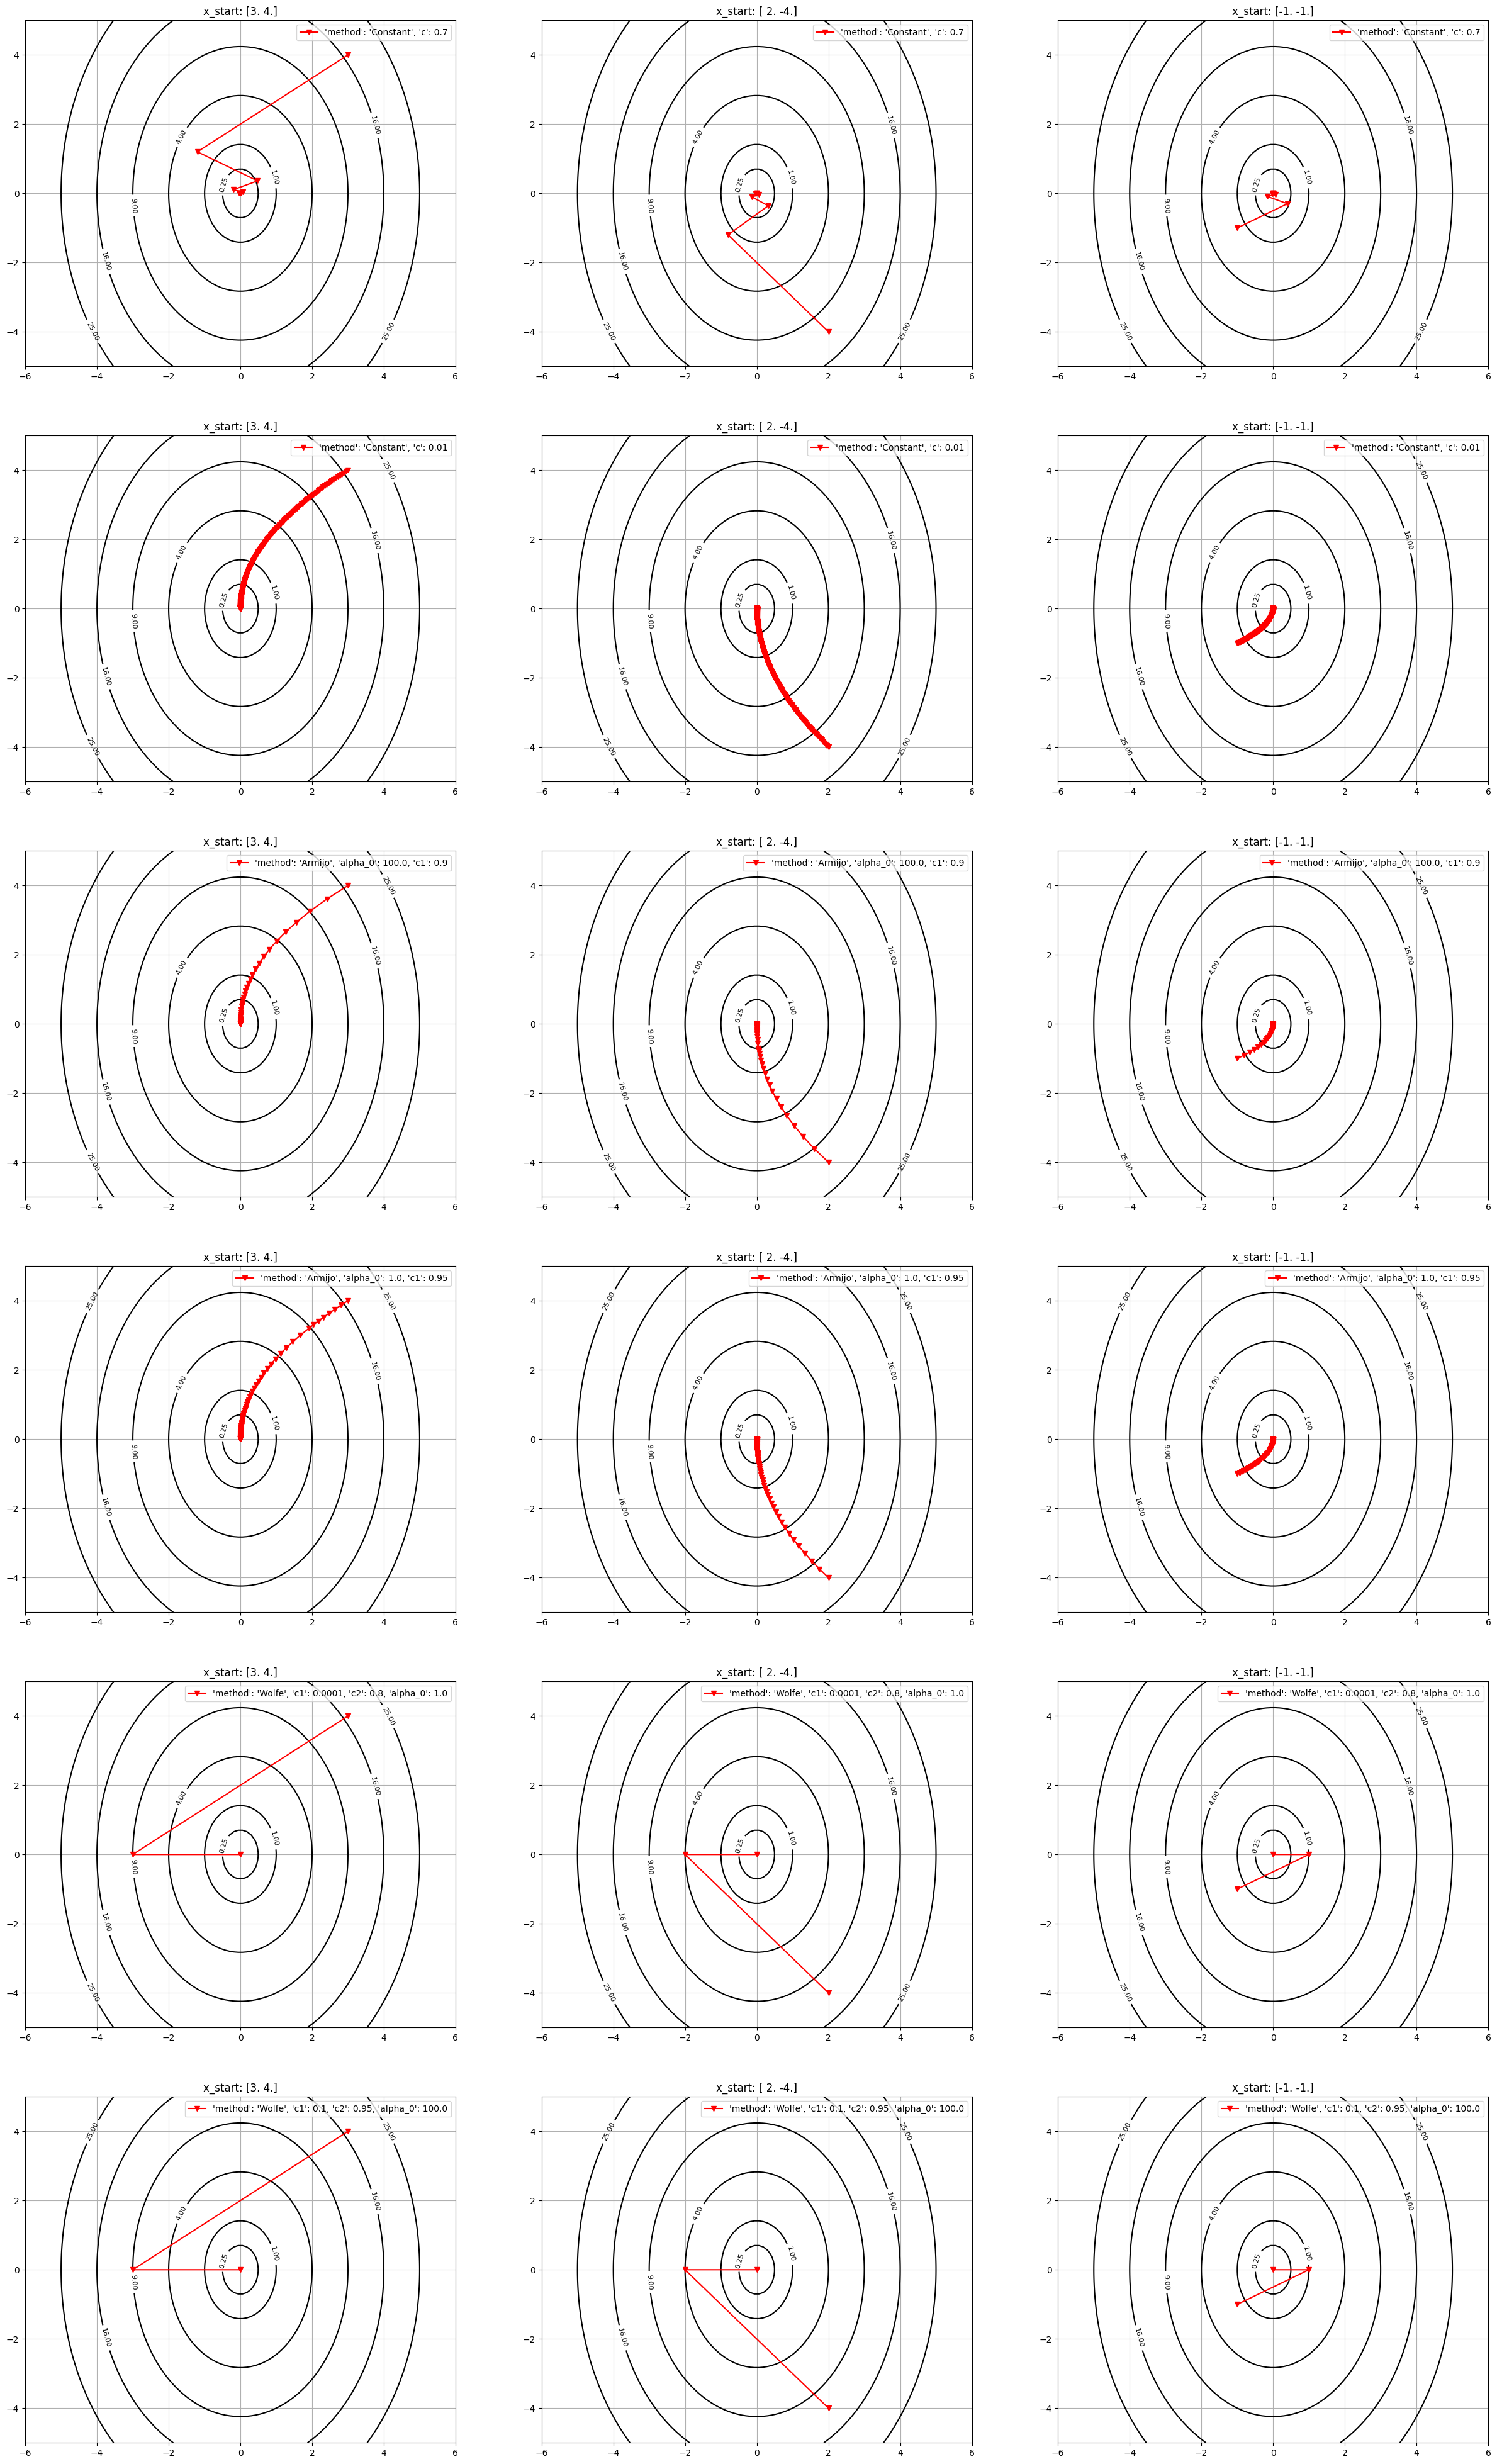

In [5]:
fig, ax = plt.subplots(len(methods), len(x_start), figsize = (30,50))
for i in range(len(methods)):
    for j in range(len(x_start)):
        [x_star, msg, history] = optimization.gradient_descent(oracle, x_start[j], line_search_options = methods[i], trace=True)
        plot_levels(oracle.func, ax[i][j])
        plot_trajectory(oracle.func, history['x'], ax[i][j], label=str(methods[i])[1:-1])
        ax[i][j].set_title("x_start: " + str(x_start[j]))
        ax[i][j].legend()

### 1.2. Плохо обусловленная матрица

In [7]:
A = np.array([[1., -1.1],[-1.1, 2.001]])
b = np.array([2., 2.2])
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))

Число обусловленности: 9.385589127686478


Ответ: метод Вульфа лучше, т. к. этот метод точнее и число итераций меньше.

В зависимости от выбора начальной точки может увеличиться число итераций.

При плохо обусловленной матрице особенно заметны колебания.

## 2. Эксперимент: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров: 1) числа обусловленности κ ≥ 1 оптимизируемой функции и 2) размерности пространства n оптимизируемых переменных.

In [8]:
K = np.arange(1, 101, 10)
options = [(10, 'r'), (100, 'b'), (1000, 'g')]
methods = [{'method': 'Constant', "c":0.01}, 
           {'method':'Armijo', 'alpha_0':1.0, 'c1':0.95}, 
           {"method":'Wolfe', 'c1':1e-3, 'c2':0.9, 'alpha_0':1.0}]

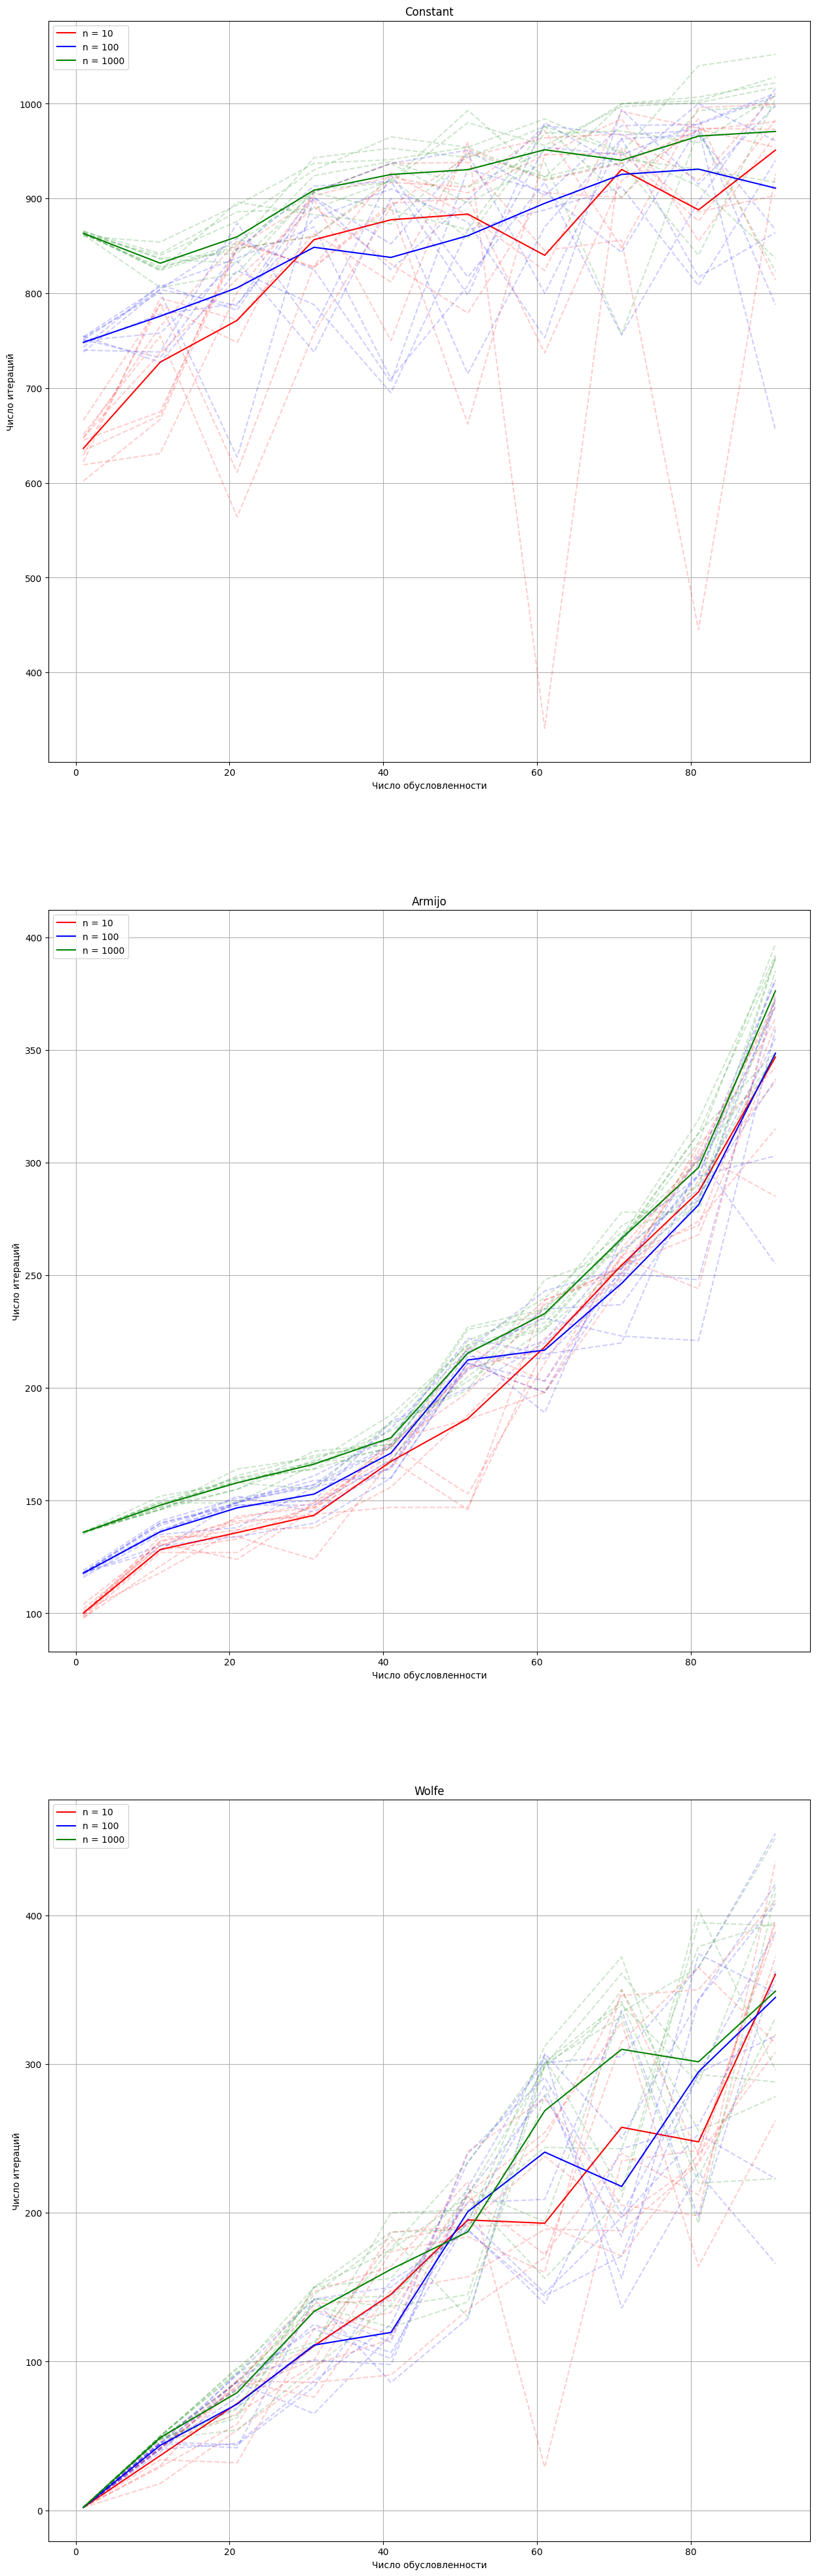

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(15,50))

for i in range(len(methods)):
    for option in options:
        I = np.zeros(len(K))
        for j in range(10):
            it = []
            for k in K:
                diag = np.random.uniform(1, k, option[0])
                diag[0] = 1.; diag[-1] = k
                A = scipy.sparse.diags(diag)
                b = np.random.rand(option[0])*k
                oracle = oracles.QuadraticOracle(A, b)
                _, _, history = optimization.gradient_descent(oracle, np.ones(option[0]), 
                                                              line_search_options = methods[i], trace=True)
                it.append(len(history['func']))
            I += np.array(it)
            ax[i].plot(K, it, color=option[1], linestyle='dashed', alpha=0.2)
        ax[i].plot(K, I / 10, color=option[1], label=('n = '+str(option[0])))
        ax[i].legend()
        ax[i].set_xlabel("Число обусловленности")
        ax[i].set_ylabel("Число итераций")
        ax[i].set_title(methods[i]['method'])
        ax[i].grid()

Ответ: Можно заметить, что размерность не сильно влияет на рост числа итераций, а с ростом числа обусловленности линейно растёт число итераций.

## 3. Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

## 3.3 Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на
реальных данных.

В качестве реальных данных используйте следующие три набора с сайта LIBSVM [http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/.](http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/.)
: *w8a*, *gisette* и *real-sim*. Коэффициент регуляризации взять стандартным образом: $λ = 1/m$.
Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать
$x_0 = 0$.

Построить графики сходимости следующих двух видов:  
1) Зависимость значения функции от реального времени работы метода.  
2) Зависимость относительного квадрата нормы градиента $‖∇f(x_k)‖^2_2 /‖∇f(x_0)‖^2_2$ (в логарифмической шкале) против реального времени работы.

При этом оба метода (градиентный спуск и Ньютон) нужно рисовать на одном и том же графике.
Укажите в отчете, какова стоимость итерации и сколько памяти требуется каждому из методов в
зависимости от параметров $m$ (размер выборки) и $n$ (размерность пространства). При оценке используйте нотацию $O(·)$, скрывающую внутри себя абсолютные константы.

Какие выводы можно сделать по результатам этого эксперимента? Какой из методов лучше и в
каких ситуациях?

**Рекомендация:** Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в фор-
мате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию `load_svmlight_file` из модуля `sklearn.datasets`. Обратите внимание, что эта функция возвращает матрицу в формате `scipy.sparse.csr_matrix`, поэтому Ваша реализация логистического оракула должна поддерживать такие матрицы.

In [11]:
A1, b1 = load_svmlight_file('data/w8a.txt')
A2, b2 = load_svmlight_file('data/gisette_scale.bz2')
A3, b3 = load_svmlight_file('data/real-sim.bz2')

In [12]:
data = [(A1, b1, "w8a"), (A2, b2, "gisette_scale"), (A3, b3, "real-sim")]

In [13]:
def visualize_time(item):
    regcoef = 1 / len(item[1])
    oracle = oracles.create_log_reg_oracle(item[0], item[1], regcoef)
    _, _, history_gd = optimization.gradient_descent(oracle, np.zeros(item[0].shape[1]), trace=True)
    _, _, history_n = optimization.newton(oracle, np.zeros(item[0].shape[1]), trace=True)

    ax[0].plot(history_gd['time'], history_gd['func'], label="Градиентный спуск")
    ax[0].plot(history_n['time'], history_n['func'], label="Ньютон")
    ax[0].set_xlabel('Время работы')
    ax[0].set_ylabel('Значение функции')
    ax[0].legend()
    ax[0].set_title(item[2])
    ax[0].grid()

    ax[1].plot(history_gd['time'], np.array(history_gd['grad_norm'])**2 / (history_gd['grad_norm'][0]**2), label="Градиентный спуск")
    ax[1].plot(history_n['time'], np.array(history_n['grad_norm'])**2 / (history_n['grad_norm'][0]**2), label="Ньютон")
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Время работы')
    ax[1].set_ylabel(r'$\vert\vert \nabla f(x_k) \vert\vert_2^2 / \vert\vert \nabla f(x_0) \vert\vert_2^2$')
    ax[1].legend()
    ax[1].set_title(item[2])
    ax[1].grid()

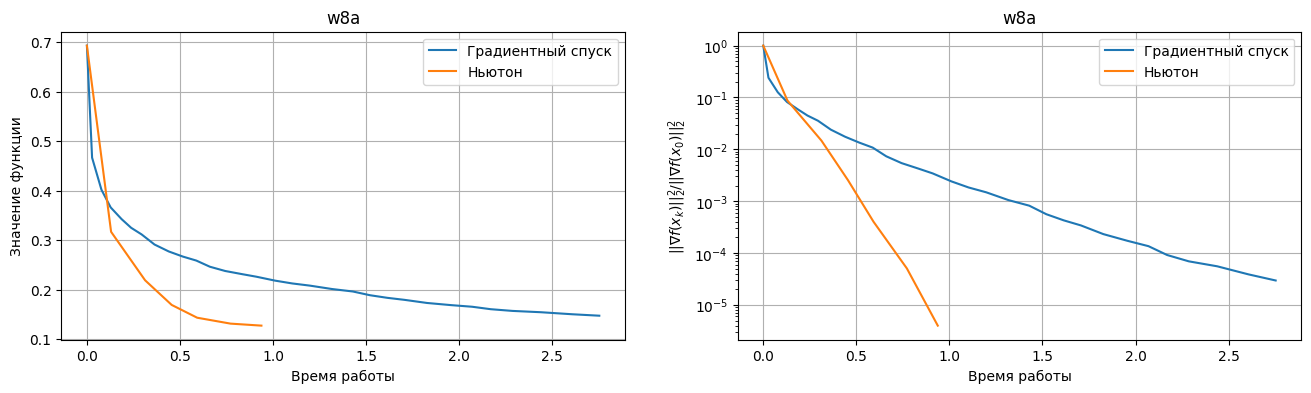

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
visualize_time(data[0])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
visualize_time(data[1])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
visualize_time(data[2])

Компьютер не смог выполнить вычисления для данных gisette_scale и real-sim. Буду делать выводы на основе данных w8a.

Ответ: Метод градиента работает быстро в начале, затем замедляется в целом требует больше времени для получения малой заданной точности.